In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import pymc3 as pm
import daft
%matplotlib inline

import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.3


In [2]:
%matplotlib inline
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from collections import defaultdict
from itertools import groupby
from sklearn import datasets
from numpy import random
from scipy.stats import dirichlet, norm, poisson

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
random.seed(1234)
import emoji

# Model 1: Nested plates

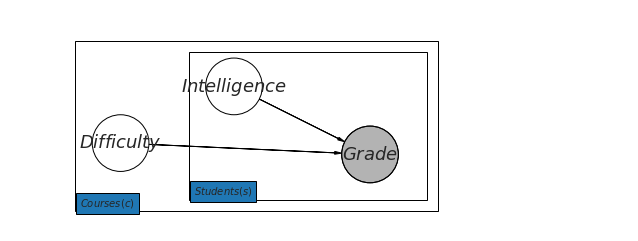

In [3]:
# create the basic daft-pgm layout, shape, size, and various styling
pgm = daft.PGM(shape=[5.5, 2], origin=[0, 0], grid_unit=4,
               label_params={'fontsize':18}, observed_style='shaded')

#distributions
pgm.add_node(daft.Node("y", r"$Grade$", 3.2, 0.7, scale=2, observed=True))
pgm.add_node(daft.Node("beta_mfr", r"$Intelligence$", 2, 1.3, scale=2))
pgm.add_node(daft.Node("beta_mfr_mu", r"$Difficulty$", 1, 0.8, scale=2))

#plate
pgm.add_plate(daft.Plate([1.6, 0.4, 2.1, 1.2], label=r"$Students(s)$", shift=-0.1))
pgm.add_plate(daft.Plate([0.6, 0.3, 3.2, 1.4], label=r"$Courses(c)$", shift=-0.1))

# draw directed edges
pgm.add_edge("beta_mfr_mu", "y")
pgm.add_edge("beta_mfr", "y")

# render
pgm.render()

Courses: c=2; Students: s=2; Grade is indexed by s and c. 
<table class="image">
<caption align="center">Nested model</caption>
<tr><td><img src="plate_model1.png",width=600,height=600/></td></tr>
</table>

# Model 2: Overlapping plates

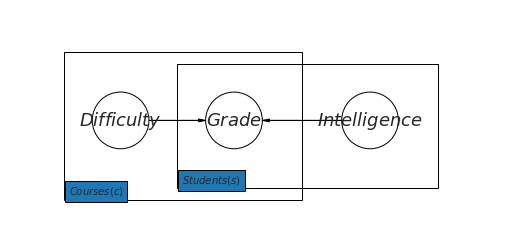

In [4]:
# create the basic daft-pgm layout, shape, size, and various styling
pgm = daft.PGM(shape=[4.5, 2], origin=[0, 0], grid_unit=4,
               label_params={'fontsize':18}, observed_style='shaded')

#cutsomer parameters
pgm.add_node(daft.Node("c", r"$Difficulty$", 1, 1, scale=2))
pgm.add_node(daft.Node("beta", r"$Intelligence$", 3.2, 1, scale=2))
pgm.add_node(daft.Node("p", r"$Grade$", 2, 1, scale=2))

#plate
pgm.add_plate(daft.Plate([1.5, 0.5, 2.3, 1], label=r"$Students(s)$", shift=-0.1))
pgm.add_plate(daft.Plate([0.5, 0.4, 2.1, 1.2], label=r"$Courses(c)$", shift=-0.1))

# draw directed edges
pgm.add_edge("c", "p")
pgm.add_edge("beta", "p")

# render
pgm.render()
plt.show()

Courses: c=2; Students: s=2; Grade is indexed by s and c. 
<table class="image">
<caption align="center">Overlapping plates</caption>
<tr><td><img src="overlapping.png",width=600,height=600/></td></tr>
</table>

#  <font color="red">Model 3: LDA as a graphical model</font>
1. Nodes are random variables;
2. Edges indicate dependence;
3. Shaded nodes are observed;
4. Unshaded nodes are hidden;
5. Plates indicate replicated variables.

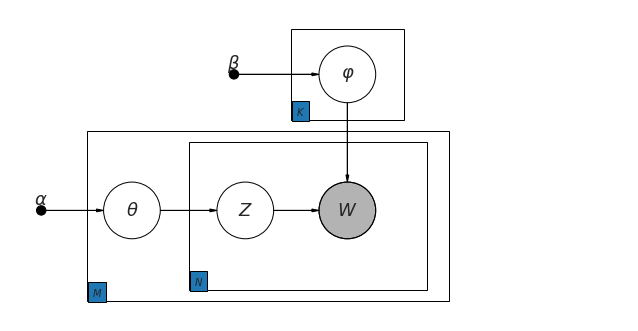

In [5]:
# create the basic daft-pgm layout, shape, size, and various styling
pgm = daft.PGM(shape=[5.5, 2.8], origin=[0, 0], grid_unit=4,
               label_params={'fontsize':18}, observed_style='shaded')

#distributions
pgm.add_node(daft.Node("beta", r"$\varphi$", 3, 2.2, scale=2))
pgm.add_node(daft.Node("y", r"$W$", 3, 1, scale=2, observed=True))
pgm.add_node(daft.Node("beta_mfr", r"$Z$", 2.1, 1, scale=2))
pgm.add_node(daft.Node("beta_mfr_mu", r"$\theta$", 1.1, 1, scale=2))
pgm.add_node(daft.Node("beta_mfr_sd", r"$\beta$", 2, 2.2, scale=2, fixed=True))
pgm.add_node(daft.Node("parent_mu", r"$\alpha$", 0.3, 1, scale=2, fixed=True)) 

# individual item plate
pgm.add_plate(daft.Plate([2.5, 1.9, 1, 0.7], label=r"$K$", shift=-0.1))
pgm.add_plate(daft.Plate([1.6, 0.4, 2.1, 1.2], label=r"$N$", shift=-0.1))
pgm.add_plate(daft.Plate([0.7, 0.3, 3.2, 1.4], label=r"$M$", shift=-0.1))

# draw directed edges
pgm.add_edge("parent_mu", "beta_mfr_mu")
pgm.add_edge("beta_mfr_mu", "beta_mfr")
pgm.add_edge("beta_mfr_sd", "beta")
pgm.add_edge("beta_mfr", "y")
pgm.add_edge("beta", "y")

# render
pgm.render()

1. k = # of topics
2. M: number of documents
3. V: number of words in the vocabulary 
4. N_i: number of words in document i.(N_i $\sim$ Poisson($\mu$).)
5. $\alpha$: proportions parameter (= 50/k)
6. $\beta$: topic parameter (= 0.01)
7. $\theta$: Per-document topic proportions (distribution of topics in document d)
8. $\varphi$: Topics (distribution of words in topic k) 
9. Z: Per-word topic assignment
10. W: Observed word


### The distributions of the variables:
\begin{equation}
\varphi_k \sim Dirichlet(\beta)\\
\theta_m \sim Dirichlet(\alpha) 
\end{equation}

# <font color="red">LDA Model:</font>
Given a collection of documents and given each word in each document:
<font color="red">
1. find the distribution over topics for each document
<br>
2. find the distribution over vocabulary for each topic
</font>

The joint defines a posterior, $p(\theta, z, \varphi|w)$. From a collection of documents, infer
1. per-word topic assignment $z$
2. per-document topic proportions $\theta$
3. per-corpus topic disstribution $\varphi$

## 1. Mixture Model for Documents: 1 document; 2 topics; 3 vocabularies

Given topic distribution by document and word distribution by topic

In [6]:
vocabulary = [ '☔️', '⛅️', '☀️']; 
boring_vocabulary = ['rainy','cloudy','sunny']
num_terms = len(vocabulary)

# Topics are distributions over vocabulary words
topic_labels = ['😨', '😃']
boring_topics = ['happy', 'sad']
topics = [[ 0.1,  0.3,  0.6],
          [ 0.8,  0.1,  0.1]]

# Proportion of documents of each topic
mixture_proportion = [0.6, 0.4]

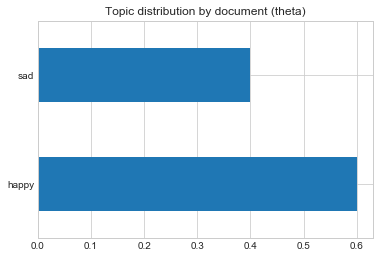

In [7]:
#only one document 
pd.Series(mixture_proportion, index=boring_topics).plot(kind='barh')
_=plt.title("Topic distribution by document (theta)")

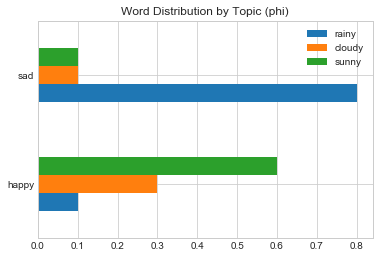

In [8]:
pd.DataFrame(topics, columns=boring_vocabulary, index=boring_topics).plot(kind='barh')
_=plt.title("Word Distribution by Topic (phi)")

## 2. Multi-topic documents: 10 documents; 2 topics; 3 vocabularies

\begin{equation}
\varphi_k \sim Dirichlet(\beta); \beta = [0.1,0.1,0.1]\\
\theta_m \sim Dirichlet(\alpha); \alpha = [25,25] 
\end{equation}



1. K = 2(number of topics)
2. $\alpha$ = [25,25] 
3. $\beta$ = [0.1,0.1,0.1] 
4. M = 10 (number of documents)
5. V =3 (number of words in the vocabulary)
6. N_i $\sim$ Poisson($\mu$ = 10) (number of words in document i)
7. $\theta \sim Dir(\alpha)$: distribution of topics in document d
8. $\varphi \sim Dir(\beta)$: distribution of words in topic k


6. Topics: $\varphi_k$; k = 1,2
7. mixture_proportion: $\theta_d$; d = 1,..,10

In [9]:
vocabulary = [ '☔️', '⛅️', '☀️']; 
num_terms = len(vocabulary)

# Topics are distributions over vocabulary words
"""
In this case, there are two topics and 3 vocabularies;
So, the size of word distribution by topic is 2 by 3
"""
topic_labels = ['😨', '😃']
topics = dirichlet([0.1, 0.1, 0.1]).rvs(2)#(3 parameters because of 3 vocabulary)
print("Word Distribution by Topic: \n",topics)

# recycle our `topics` sampled from the Dirichlet distribution
docs = defaultdict(lambda: defaultdict(str))
for doc_index in range(10):    
    # the length of each document
    doc_len = poisson(mu=10).rvs(size=1)
    
    # Proportion of documents of each topic(there are two parameters because of 2 topics)
    mixture_proportion = dirichlet([25, 25]).rvs()[0]
    print("Topic Distribution by document %s: \n %s"%(doc_index+1,mixture_proportion))
    
    for word in range(doc_len[0]):
        topic = random.choice(topic_labels, p=mixture_proportion)
        word_dist = topics[topic_labels.index(topic)]
        word = random.choice(vocabulary, p=word_dist)
        docs[doc_index+1][topic] += word        
        docs[doc_index+1][topic] = ''.join(sorted(docs[doc_index+1][topic]))

Word Distribution by Topic: 
 [[  7.94279536e-07   3.08947863e-03   9.96909727e-01]
 [  2.97055418e-06   9.99957850e-01   3.91796522e-05]]
Topic Distribution by document 1: 
 [ 0.65099538  0.34900462]
Topic Distribution by document 2: 
 [ 0.53284764  0.46715236]
Topic Distribution by document 3: 
 [ 0.52589019  0.47410981]
Topic Distribution by document 4: 
 [ 0.52439694  0.47560306]
Topic Distribution by document 5: 
 [ 0.48275617  0.51724383]
Topic Distribution by document 6: 
 [ 0.35301783  0.64698217]
Topic Distribution by document 7: 
 [ 0.44436988  0.55563012]
Topic Distribution by document 8: 
 [ 0.36083002  0.63916998]
Topic Distribution by document 9: 
 [ 0.56882908  0.43117092]
Topic Distribution by document 10: 
 [ 0.53024402  0.46975598]


In [10]:
for doc_id, doc in docs.items():
    print("Doc {:02d}".format(doc_id))
    for topic, words in doc.items():
        print("  Words from topic {}: {}".format(topic, words))

Doc 01
  Words from topic 😃: ⛅⛅⛅⛅⛅️️️️️
  Words from topic 😨: ☀☀☀☀☀☀☀️️️️️️️
Doc 02
  Words from topic 😨: ☀☀☀☀☀☀️️️️️️
  Words from topic 😃: ⛅⛅⛅⛅⛅️️️️️
Doc 03
  Words from topic 😨: ☀☀☀☀️️️️
  Words from topic 😃: ⛅⛅⛅⛅⛅⛅️️️️️️
Doc 04
  Words from topic 😨: ☀☀☀☀☀☀☀☀️️️️️️️️
  Words from topic 😃: ⛅⛅⛅⛅⛅️️️️️
Doc 05
  Words from topic 😃: ⛅⛅⛅⛅⛅⛅️️️️️️
  Words from topic 😨: ☀☀️️
Doc 06
  Words from topic 😨: ☀☀️️
  Words from topic 😃: ⛅⛅⛅⛅⛅⛅⛅⛅️️️️️️️️
Doc 07
  Words from topic 😃: ⛅⛅⛅️️️
  Words from topic 😨: ☀☀☀️️️
Doc 08
  Words from topic 😃: ⛅⛅⛅⛅⛅⛅️️️️️️
  Words from topic 😨: ☀☀☀☀️️️️
Doc 09
  Words from topic 😨: ☀☀☀☀☀☀☀☀☀️️️️️️️️️
  Words from topic 😃: ⛅⛅⛅⛅⛅⛅️️️️️️
Doc 10
  Words from topic 😃: ⛅⛅⛅⛅⛅⛅⛅⛅⛅⛅️️️️️️️️️️
  Words from topic 😨: ☀☀☀☀☀☀☀️️️️️️️
